In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
import re
import nltk

from nltk.corpus import stopwords  # Importando stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize  # Importando word_tokenize
# import ace_tools as tools

# Baixa os stopwords em inglês (remova se já tiver baixado anteriormente)
nltk.download('stopwords')

nltk.download('wordnet')  # WordNet para lematização
nltk.download('omw-1.4')  # WordNet data for other languages

# from scipy.linalg import triu
from gensim import corpora
# from gensim.models import LdaModel  
from gensim.models.ldamulticore import LdaMulticore


import os
import sys
import warnings
import multiprocessing

multiprocessing.set_start_method("spawn", force=True)
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# os.environ["JOBLIB_MULTIPROCESSING"] = "loky"



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mborges/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mborges/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mborges/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [46]:
books_rating = pd.read_csv('Books_rating.csv')
books_rating

,Id,Title,Price,User_id,profileName,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...,...,...,...,...
2999995,B000NSLVCU,The Idea of History,NaN,NaN,NaN,4.0,937612800,Difficult,"This is an extremely difficult book to digest,..."
2999996,B000NSLVCU,The Idea of History,NaN,A1SMUB9ASL5L9Y,jafrank,4.0,1331683200,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...
2999997,B000NSLVCU,The Idea of History,NaN,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",4.0,1180224000,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i..."
2999998,B000NSLVCU,The Idea of History,NaN,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",5.0,1163030400,"Yes, it is cheaper than the University Bookstore","My daughter, a freshman at Indiana University,..."


In [4]:
# Conforme observado, é necessário reduzir o número de amostrar no arquivo CSV para que seja capaz fazer o processamento do mesmo.
# O MOTIVO foi observado a falta de processamento pararelo, causando um consumo muito grande de memoria ram o casionando desligamento do kernel do ambiente jupyter notebook. 

In [5]:
books_rating = books_rating[0:4000]
books_rating

,Id,Title,Price,User_id,profileName,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...,...,...,...,...
3995,0974267600,How to Own Your Home Years Sooner - without ma...,25.0,AMV10R07WE8QK,"Shawn K. ""Sue B.""",5.0,1095811200,A MUST READ FOR ALL HOMEOWNERS/FUTURE HOME OWNERS,"I was a bit skeptical at first, but now, I thi..."
3996,0974267600,How to Own Your Home Years Sooner - without ma...,25.0,A10ZUIEVIYNUUM,Brian,5.0,1082505600,This book is a rare jewel.,Never before have I read or even heard of anyt...
3997,0974267600,How to Own Your Home Years Sooner - without ma...,25.0,A3HDIEKLAK0N3E,Desiree Wells,5.0,1088467200,How to own your home years sooner,"The mortgage elimination system is so simple, ..."
3998,0974267600,How to Own Your Home Years Sooner - without ma...,25.0,A13T294ZRG4LTM,j s henneberry,5.0,1353110400,Very Knowledgeble author,New financial products are now in the Australi...


# Analise exploratorio para books_rating
Limpeza do dataframe booke_rating

In [7]:
books_rating.dtypes

Id              object
Title           object
Price          float64
User_id         object
profileName     object
score          float64
time             int64
summary         object
text            object
dtype: object

In [8]:
books_rating.isna().sum() # resultdo da contagem de NaN em cada coluna

Id                0
Title             0
Price          3501
User_id         813
profileName     813
score             0
time              0
summary           1
text              0
dtype: int64

In [9]:
""" para o preenchimento da colunas onde há valores valores ausentes, foi escolhido mudar por desconcido e 
    a coluna Price pegar a media de preços dos livros para ser colocado no lugar de NaN
"""

# utilizando o método assing para evistar copias redundantes no dataframe e excevio consumo de mémoria
books_rating = books_rating.assign(
    Price=books_rating['Price'].fillna(books_rating['Price'].mean()),
    User_id=books_rating['User_id'].fillna('UNKNOWN'),
    Title=books_rating['Title'].fillna('UNKNOWN'),
    profileName=books_rating['profileName'].fillna('UNKNOWN'),
    summary=books_rating['summary'].fillna('UNKNOWN'),
    text=books_rating['text'].fillna('UNKNOWN')
)
books_rating.isna().sum() # resultdo da contagem de NaN em cada coluna

Id             0
Title          0
Price          0
User_id        0
profileName    0
score          0
time           0
summary        0
text           0
dtype: int64

In [10]:
books_rating.head(4)

,Id,Title,Price,User_id,profileName,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,19.336152,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,19.336152,A30TK6U7DNS82R,Kevin Killian,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,19.336152,A3UH4UZ4RSVO82,John Granger,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,19.336152,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."


In [11]:
# Analise exploratoria mais detalhadas
# Converter a coluna 'time' do formato Unix
books_rating['time'] = pd.to_datetime(books_rating['time'], unit='s')
books_rating['time']

0      1999-10-23
1      2004-09-21
2      2004-03-09
3      2004-07-25
4      2005-02-10
          ...    
3995   2004-09-22
3996   2004-04-21
3997   2004-06-29
3998   2012-11-17
3999   2011-04-13
Name: time, Length: 4000, dtype: datetime64[ns]

In [12]:
# Selecione apenas as colunas numéricas para análise exploratória
numeric_data = books_rating.select_dtypes(include=['float64', 'int64'])

# Estatísticas resumidas para as colunas numéricas
numeric_data.describe()

,Price,score
count,4000.000000,4000.000000
mean,19.336152,4.114000
std,4.756408,1.256741
min,3.990000,1.000000
25%,19.336152,4.000000
50%,19.336152,5.000000
75%,19.336152,5.000000
max,97.500000,5.000000


In [13]:
# Verificar as datas mais recentes na coluna
print("\nVerificar as datas mais recentes na coluna")
books_rating['time'].sort_values(ascending=False).head(10)


Verificar as datas mais recentes na coluna


3227   2013-03-02
2924   2013-02-28
606    2013-02-27
1701   2013-02-27
3496   2013-02-26
3125   2013-02-26
154    2013-02-25
3216   2013-02-23
136    2013-02-23
738    2013-02-23
Name: time, dtype: datetime64[ns]

In [14]:
# Verificar as maiores pontuações de avaliação (score) no dataset
print("\nVerificar as maiores pontuações de avaliação (score) no dataset")

books_rating[['score', 'Title', 'time']].sort_values(by='time', ascending=False).head(10)


Verificar as maiores pontuações de avaliação (score) no dataset


,score,Title,time
3227,2.0,The Night Horseman (Sagebrush Largeprint Weste...,2013-03-02
2924,5.0,Florida Birds: An Introduction to Familiar Spe...,2013-02-28
606,4.0,How to Discipline Kids without Losing Their Lo...,2013-02-27
1701,5.0,Compendium of Herbal Magick,2013-02-27
3496,5.0,The Portable Poe: 2,2013-02-26
3125,3.0,Immodest Acts: The Life of a Lesbian Nun in Re...,2013-02-26
154,5.0,Hunting The Hard Way,2013-02-25
3216,5.0,Howard Zinn on History,2013-02-23
136,5.0,Eyewitness Travel Guide to Europe,2013-02-23
738,5.0,The Scarletti Curse (Candleglow),2013-02-23



Plotando a distribuição das pontuações (score)



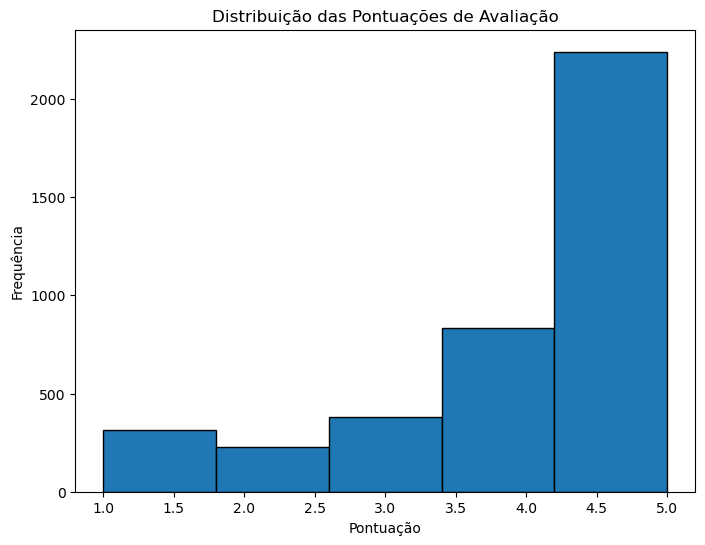

In [15]:
import matplotlib.pyplot as plt

# Plotando a distribuição das pontuações (score)
print("\nPlotando a distribuição das pontuações (score)\n")

plt.figure(figsize=(8, 6))
plt.hist(books_rating['score'], bins=5, edgecolor='black')
plt.title('Distribuição das Pontuações de Avaliação')
plt.xlabel('Pontuação')
plt.ylabel('Frequência')
plt.show();

In [16]:
# Exibir os títulos com mais avaliações
# Contar a quantidade de avaliações por título e ordenar para encontrar os mais avaliados

top_reviewed_titles = books_rating['Title'].value_counts().head(10) # escolhido 10  titulos
top_reviewed_titles_df = top_reviewed_titles.reset_index()
top_reviewed_titles_df.columns = ['Title', 'Review_Count']

print("\nTítulos com mais avaliações")
top_reviewed_titles_df


Títulos com mais avaliações


,Title,Review_Count
0,The Scarlet Letter A Romance,758
1,Economics in one lesson,330
2,From Potter's Field,157
3,Night World: Daughters Of Darkness,134
4,Cruel and Unusual (G K Hall Large Print Book S...,124
5,The Castle in the Attic,118
6,Island,103
7,The Scarletti Curse (Candleglow),97
8,Edge of Danger,76
9,Plain And Simple - A Woman's Journey To The Amish,55


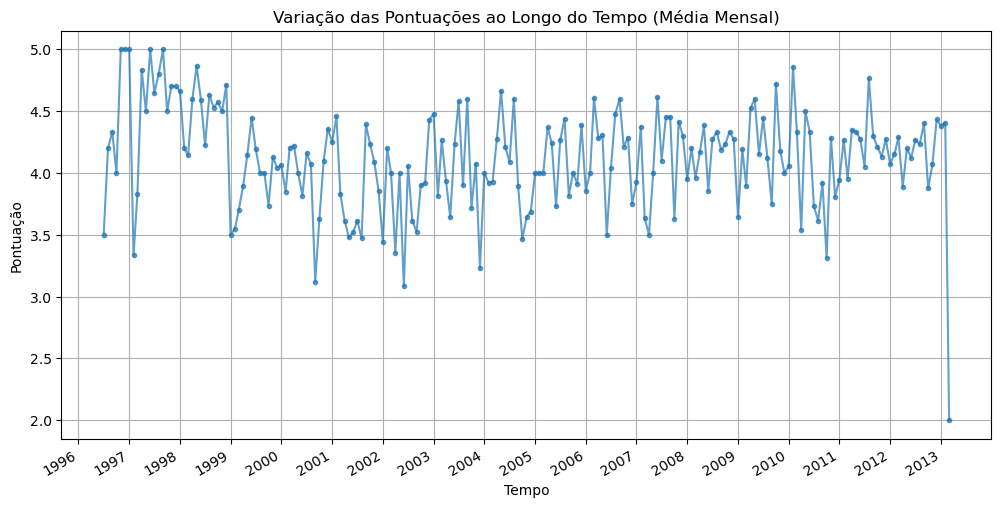

In [17]:
# Ordenar os dados por data para uma análise temporal
data_sorted = books_rating.sort_values(by='time')

# Reduzir a granularidade das datas para a média anual das pontuações
data_grouped = data_sorted.groupby(data_sorted['time'].dt.to_period('M')).agg({'score': 'mean'}).reset_index()
data_grouped['time'] = data_grouped['time'].dt.to_timestamp()  # Converter Period para Timestamp

# Plotando a variação das pontuações ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(data_grouped['time'], data_grouped['score'], marker='o', linestyle='-', markersize=3, alpha=0.7)

plt.title('Variação das Pontuações ao Longo do Tempo (Média Mensal)')
plt.xlabel('Tempo')
plt.ylabel('Pontuação')
plt.grid(True)

# Formatando eixos para melhor visualização
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotacionar datas para melhor leitura

plt.show()


/tmp/ipykernel_12481/1233687742.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data_sorted['time'].dt.year, y=data_sorted['score'], palette="Set3")


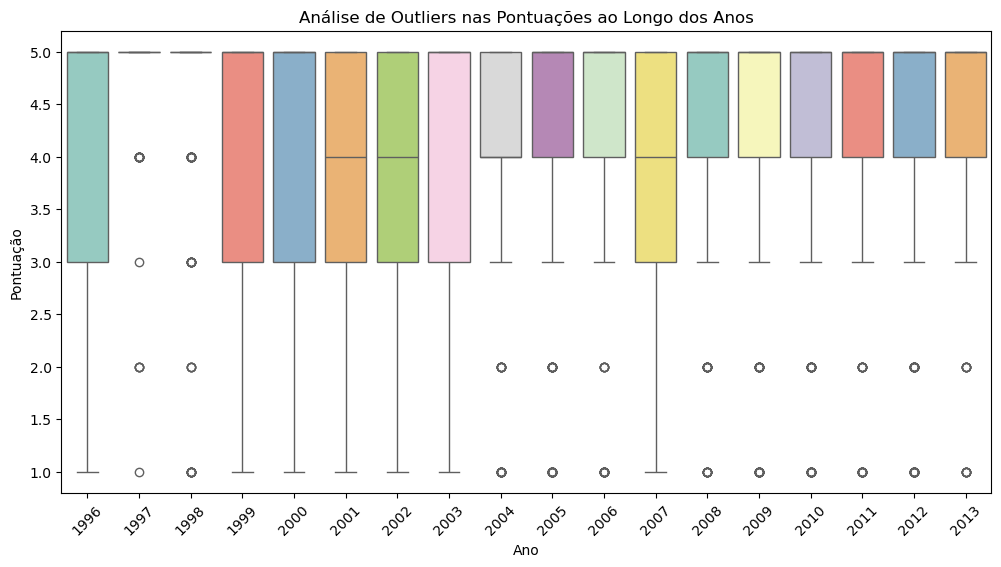

In [18]:
# Analisar outliers nas pontuações ao longo do tempo

# Configurar o tamanho da figura
plt.figure(figsize=(12, 6))

# Criar um boxplot para visualizar outliers nas pontuações ao longo do tempo
sns.boxplot(x=data_sorted['time'].dt.year, y=data_sorted['score'], palette="Set3")
plt.title('Análise de Outliers nas Pontuações ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Pontuação')
plt.xticks(rotation=45)

plt.show();

### O boxplot acima mostra a análise de outliers nas pontuações ao longo dos anos. Ele ajuda a identificar anos com avaliações que se destacam (acima ou abaixo do padrão), indicando períodos de maior variação nas opiniões d os leitores.

In [20]:
# Quais anos tiveram mais avaliações baixas?

# Filtrar as avaliações baixas (definidas como pontuações menores ou iguais a 2) e contar por ano
low_scores = books_rating[books_rating['score'] <= 2]
low_scores_per_year = low_scores['time'].dt.year.value_counts().sort_index()

# Exibir os anos com maior quantidade de avaliações baixas
low_scores_per_year_df = low_scores_per_year.reset_index()
low_scores_per_year_df.columns = ['Year', 'Low_Score_Count']

low_scores_per_year_df.head(5)

,Year,Low_Score_Count
0,1996,2
1,1997,5
2,1998,14
3,1999,60
4,2000,53


In [21]:
# Remove caracteres especiais, pontuação e números, e converte para letras minúsculas da coluna 'summary'

books_rating['cleaned_summary'] = books_rating['summary'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower()) 

# Remove caracteres especiais, pontuação e números, e converte para letras minúsculas na coluna 'text'
books_rating['cleaned_text'] = books_rating['text'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

# Exibe as colunas originais e as colunas limpas para verificação
books_rating[['summary', 'cleaned_summary', 'text', 'cleaned_text']].head(8)


,summary,cleaned_summary,text,cleaned_text
0,Nice collection of Julie Strain images,nice collection of julie strain images,This is only for Julie Strain fans. It's a col...,this is only for julie strain fans its a colle...
1,Really Enjoyed It,really enjoyed it,I don't care much for Dr. Seuss but after read...,i dont care much for dr seuss but after readin...
2,Essential for every personal and Public Library,essential for every personal and public library,"If people become the books they read and if ""t...",if people become the books they read and if th...
3,Phlip Nel gives silly Seuss a serious treatment,phlip nel gives silly seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",theodore seuss geisel aka quotdr seussquot wa...
4,Good academic overview,good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,philip nel dr seuss american iconthis is basi...
5,One of America's greatest creative talents,one of americas greatest creative talents,"""Dr. Seuss: American Icon"" by Philip Nel is a ...",dr seuss american icon by philip nel is a thou...
6,A memorably excellent survey of Dr. Seuss' man...,a memorably excellent survey of dr seuss many ...,Theodor Seuss Giesel was best known as 'Dr. Se...,theodor seuss giesel was best known as dr seus...
7,Academia At It's Best,academia at its best,When I recieved this book as a gift for Christ...,when i recieved this book as a gift for christ...


In [22]:
# Define os stopwords em inglês
stop_words = set(stopwords.words('english'))

# Remove stopwords da coluna 'cleaned_summary'
books_rating['cleaned_summary_no_stopwords'] = books_rating['cleaned_summary'].apply(
    lambda x: ' '.join([word for word in str(x).split() if word not in stop_words])
)

# Remove stopwords da coluna 'cleaned_text'
books_rating['cleaned_text_no_stopwords'] = books_rating['cleaned_text'].apply(
    lambda x: ' '.join([word for word in str(x).split() if word not in stop_words])
)

# Exibir as colunas com stopwords e  sem stopwords para verificação
books_rating[['cleaned_summary', 'cleaned_summary_no_stopwords', 'cleaned_text', 'cleaned_text_no_stopwords']].head()

,cleaned_summary,cleaned_summary_no_stopwords,cleaned_text,cleaned_text_no_stopwords
0,nice collection of julie strain images,nice collection julie strain images,this is only for julie strain fans its a colle...,julie strain fans collection photos pages wort...
1,really enjoyed it,really enjoyed,i dont care much for dr seuss but after readin...,dont care much dr seuss reading philip nels bo...
2,essential for every personal and public library,essential every personal public library,if people become the books they read and if th...,people become books read child father man dr s...
3,phlip nel gives silly seuss a serious treatment,phlip nel gives silly seuss serious treatment,theodore seuss geisel aka quotdr seussquot wa...,theodore seuss geisel aka quotdr seussquot one...
4,good academic overview,good academic overview,philip nel dr seuss american iconthis is basi...,philip nel dr seuss american iconthis basicall...


In [23]:
# Realizando a tokenização nas colunas de texto limpo e sem stopwords
books_rating['tokenized_summary'] = books_rating['cleaned_summary_no_stopwords'].apply(lambda x: x.split())
books_rating['tokenized_text']    = books_rating['cleaned_text_no_stopwords'].apply(lambda x: x.split())

# Exibindo as colunas com tokens e já tokenizadas para verificação
books_rating[['cleaned_summary_no_stopwords', 'tokenized_summary', 'cleaned_text_no_stopwords', 'tokenized_text']].head(6)


,cleaned_summary_no_stopwords,tokenized_summary,cleaned_text_no_stopwords,tokenized_text
0,nice collection julie strain images,"[nice, collection, julie, strain, images]",julie strain fans collection photos pages wort...,"[julie, strain, fans, collection, photos, page..."
1,really enjoyed,"[really, enjoyed]",dont care much dr seuss reading philip nels bo...,"[dont, care, much, dr, seuss, reading, philip,..."
2,essential every personal public library,"[essential, every, personal, public, library]",people become books read child father man dr s...,"[people, become, books, read, child, father, m..."
3,phlip nel gives silly seuss serious treatment,"[phlip, nel, gives, silly, seuss, serious, tre...",theodore seuss geisel aka quotdr seussquot one...,"[theodore, seuss, geisel, aka, quotdr, seussqu..."
4,good academic overview,"[good, academic, overview]",philip nel dr seuss american iconthis basicall...,"[philip, nel, dr, seuss, american, iconthis, b..."
5,one americas greatest creative talents,"[one, americas, greatest, creative, talents]",dr seuss american icon philip nel thoughtful d...,"[dr, seuss, american, icon, philip, nel, thoug..."


In [24]:
# Inicializando o Stemmer e o Lemmatizer para inglês
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Aplicando lematização e stemming nos tokens de 'tokenized_summary' e 'tokenized_text'
books_rating['stemmed_summary'] = books_rating['tokenized_summary'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
books_rating['stemmed_text']    = books_rating['tokenized_text'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

# Exibindo as colunas com tokens lematizados e reduzidos
books_rating[['tokenized_summary', 'stemmed_summary', 'tokenized_text', 'stemmed_text']].head()

,tokenized_summary,stemmed_summary,tokenized_text,stemmed_text
0,"[nice, collection, julie, strain, images]","[nice, collect, juli, strain, imag]","[julie, strain, fans, collection, photos, page...","[juli, strain, fan, collect, photo, page, wort..."
1,"[really, enjoyed]","[realli, enjoy]","[dont, care, much, dr, seuss, reading, philip,...","[dont, care, much, dr, seuss, read, philip, ne..."
2,"[essential, every, personal, public, library]","[essenti, everi, person, public, librari]","[people, become, books, read, child, father, m...","[peopl, becom, book, read, child, father, man,..."
3,"[phlip, nel, gives, silly, seuss, serious, tre...","[phlip, nel, give, silli, seuss, seriou, treat...","[theodore, seuss, geisel, aka, quotdr, seussqu...","[theodor, seuss, geisel, aka, quotdr, seussquo..."
4,"[good, academic, overview]","[good, academ, overview]","[philip, nel, dr, seuss, american, iconthis, b...","[philip, nel, dr, seuss, american, iconthi, ba..."


In [25]:

from collections import Counter

# Juntando todos os tokens da coluna 'stemmed_text' para análise de frequência
all_stemmed_words = [word for tokens in books_rating['stemmed_text'] for word in tokens]

# Contando a frequência de cada palavra
word_frequency = Counter(all_stemmed_words)

# Convertendo para DataFrame para visualização
word_frequency_df = pd.DataFrame(word_frequency.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Exibindo o DataFrame de frequência de palavras ao usuário

print("\nAnalisar frequência de palavras no texto\n")
word_frequency_df


Analisar frequência de palavras no texto



,word,frequency
27,book,8361
44,read,4008
26,one,2360
34,like,1644
528,stori,1533
...,...,...
12473,groupsa,1
12474,poorerhazlitt,1
12476,forgottena,1
12480,veloc,1


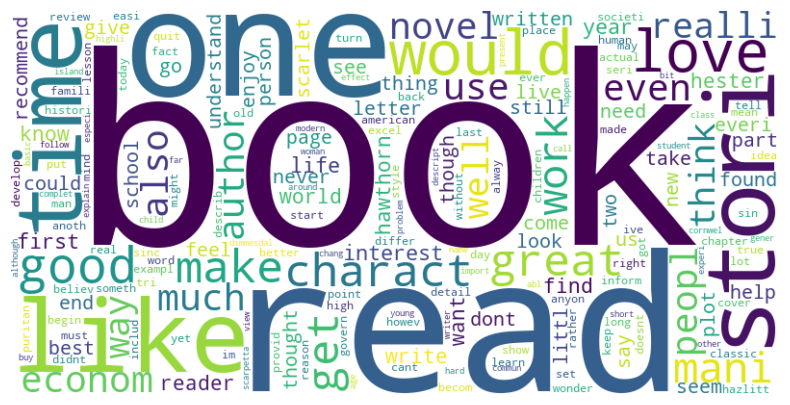

In [26]:
# Gerando a nuvem de palavras com base nas frequências
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequency)

# Exibindo a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

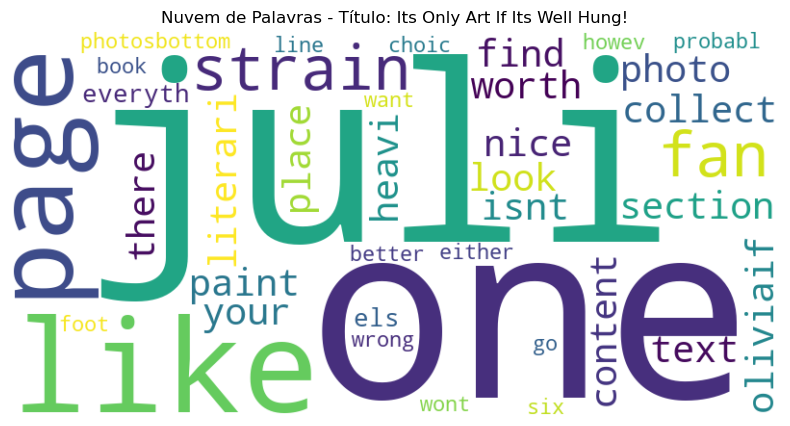

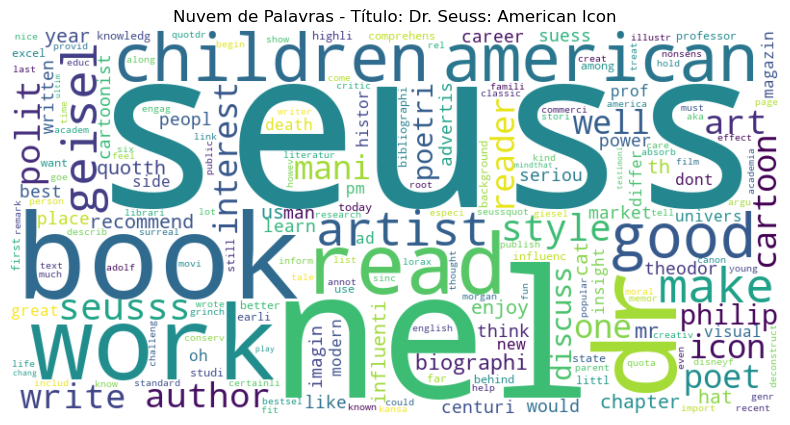

In [27]:
# Criando uma nuvem de palavras por título de livro
# Vamos agrupar os dados por título e gerar uma nuvem para cada um

# Selecionando um título de exemplo para visualização (se houver muitos títulos)
example_titles = books_rating['Title'].unique()[:2]  # Selecionando apenas 3 títulos para exemplo

# Gerando e exibindo a nuvem de palavras para cada título selecionado
for title in example_titles:
    # Filtrando as palavras do texto stemmed para o título específico
    words = [word for tokens in books_rating[books_rating['Title'] == title]['stemmed_text'] for word in tokens]
    word_freq = Counter(words)
    
    # Gerando a nuvem de palavras para o título
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Exibindo a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuvem de Palavras - Título: {title}")
    plt.show()


In [28]:
"""
Para realizar uma análise de sentimento nos resumos ou descrições dos livros, é utlizado a  biblioteca TextBlob.
A TextBlob calcula o sentimento de cada texto, retornando uma polaridade que varia de -1 (muito negativo) a +1 (muito positivo)
"""

# Aplicando a análise de sentimento diretamente nos resumos limpos e sem stopwords
books_rating['summary_sentiment'] = books_rating['cleaned_summary_no_stopwords'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Exibindo o DataFrame com o sentimento dos resumos
print('\nExibindo o DataFrame com o sentimento dos resumos\n')
books_rating[['Title', 'cleaned_summary_no_stopwords', 'summary_sentiment']].head(6)


Exibindo o DataFrame com o sentimento dos resumos



,Title,cleaned_summary_no_stopwords,summary_sentiment
0,Its Only Art If Its Well Hung!,nice collection julie strain images,0.600000
1,Dr. Seuss: American Icon,really enjoyed,0.500000
2,Dr. Seuss: American Icon,essential every personal public library,0.000000
3,Dr. Seuss: American Icon,phlip nel gives silly seuss serious treatment,-0.416667
4,Dr. Seuss: American Icon,good academic overview,0.350000
5,Dr. Seuss: American Icon,one americas greatest creative talents,0.750000


In [29]:
# Filtrando os resumos que possuem sentimento negativo
negative_summaries_df = books_rating[books_rating['summary_sentiment'] < 0][['Title', 'cleaned_summary_no_stopwords', 'summary_sentiment']]
print("\nResumos com Sentimento Negativo\n")

negative_summaries_df.head(4)


Resumos com Sentimento Negativo



,Title,cleaned_summary_no_stopwords,summary_sentiment
3,Dr. Seuss: American Icon,phlip nel gives silly seuss serious treatment,-0.416667
13,Wonderful Worship in Smaller Churches,small church pastor book worship,-0.250000
27,Whispers of the Wicked Saints,worst,-1.000000
38,Whispers of the Wicked Saints,awful beyond belief,-1.000000


In [30]:
# Agrupe sentimentos por pontuação de livros

# Agrupando a média dos sentimentos por pontuação dos livros
sentiment_by_score_df = books_rating.groupby('score')['summary_sentiment'].mean().reset_index()

print("\nGrupo de sentimentos por pontuação de livros\n")
sentiment_by_score_df


Grupo de sentimentos por pontuação de livros



,score,summary_sentiment
0,1.0,-0.169634
1,2.0,-0.027253
2,3.0,0.120352
3,4.0,0.252734
4,5.0,0.319407


In [31]:
# Criando um dicionário e uma matriz de frequência para a coluna 'stemmed_text'

from gensim.models.coherencemodel import CoherenceModel 

# Criando um dicionário e uma matriz de frequência para a coluna 'stemmed_text'
dictionary = corpora.Dictionary(books_rating['stemmed_text'])
corpus = [dictionary.doc2bow(text) for text in books_rating['stemmed_text']]

# Treinando o modelo LDA com LdaMulticore usando 20 tópicos para mais precisão
lda_model = LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=10, random_state=42, workers=4)

# Exibindo os principais tópicos identificados
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic,"\n")

# Avaliando a coerência dos tópicos
coherence_model = CoherenceModel(model=lda_model, texts=books_rating['stemmed_text'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"\nCoerência dos Tópicos: {coherence_score}\n\n")

(0, '0.010*"scarpetta" + 0.009*"book" + 0.007*"kay" + 0.007*"cornwel" + 0.007*"de"') 

(1, '0.047*"book" + 0.030*"read" + 0.010*"like" + 0.008*"one" + 0.005*"get"') 

(2, '0.014*"hawthorn" + 0.014*"book" + 0.014*"hester" + 0.012*"stori" + 0.011*"read"') 

(3, '0.037*"book" + 0.014*"read" + 0.007*"author" + 0.006*"make" + 0.005*"life"') 

(4, '0.010*"book" + 0.009*"one" + 0.005*"would" + 0.005*"pain" + 0.005*"read"') 

(5, '0.012*"book" + 0.006*"love" + 0.005*"one" + 0.004*"mani" + 0.004*"work"') 

(6, '0.051*"book" + 0.022*"read" + 0.010*"one" + 0.008*"great" + 0.007*"would"') 

(7, '0.023*"book" + 0.011*"love" + 0.011*"read" + 0.009*"like" + 0.008*"one"') 

(8, '0.009*"book" + 0.006*"cat" + 0.006*"greek" + 0.006*"rabbi" + 0.005*"one"') 

(9, '0.021*"econom" + 0.016*"book" + 0.009*"one" + 0.008*"hazlitt" + 0.006*"govern"') 


Coerência dos Tópicos: 0.34245395977078064




In [32]:
import pyLDAvis.gensim
import pyLDAvis

# Visualização com pyLDAvis
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=12481) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=12481) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=12481) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=12481) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/lo

## <br/><br/>Os principais tópicos identificados pelo modelo LDA para os livros incluem conjuntos de palavras frequentemente associadas, indicando possíveis temas. Abaixo é indentificado cinco tópicos principais:

In [34]:
# Extraindo os tópicos para cada documento (livro) no corpus
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]

# Criando uma lista com o tópico mais relevante (de maior peso) para cada livro
book_topics = []
for doc_topic in doc_topics:
    # Ordena os tópicos do documento pela relevância e pega o tópico mais relevante
    dominant_topic = sorted(doc_topic, key=lambda x: -x[1])[0][0]
    book_topics.append(dominant_topic)

# Adicionando os tópicos dominantes aos dados
books_rating['Dominant_Topic'] = book_topics

# Exibindo os títulos e seus tópicos dominantes
books_rating[['Title', 'Dominant_Topic']].head(5)


,Title,Dominant_Topic
0,Its Only Art If Its Well Hung!,6
1,Dr. Seuss: American Icon,1
2,Dr. Seuss: American Icon,1
3,Dr. Seuss: American Icon,1
4,Dr. Seuss: American Icon,1


<Figure size 1400x1000 with 0 Axes>

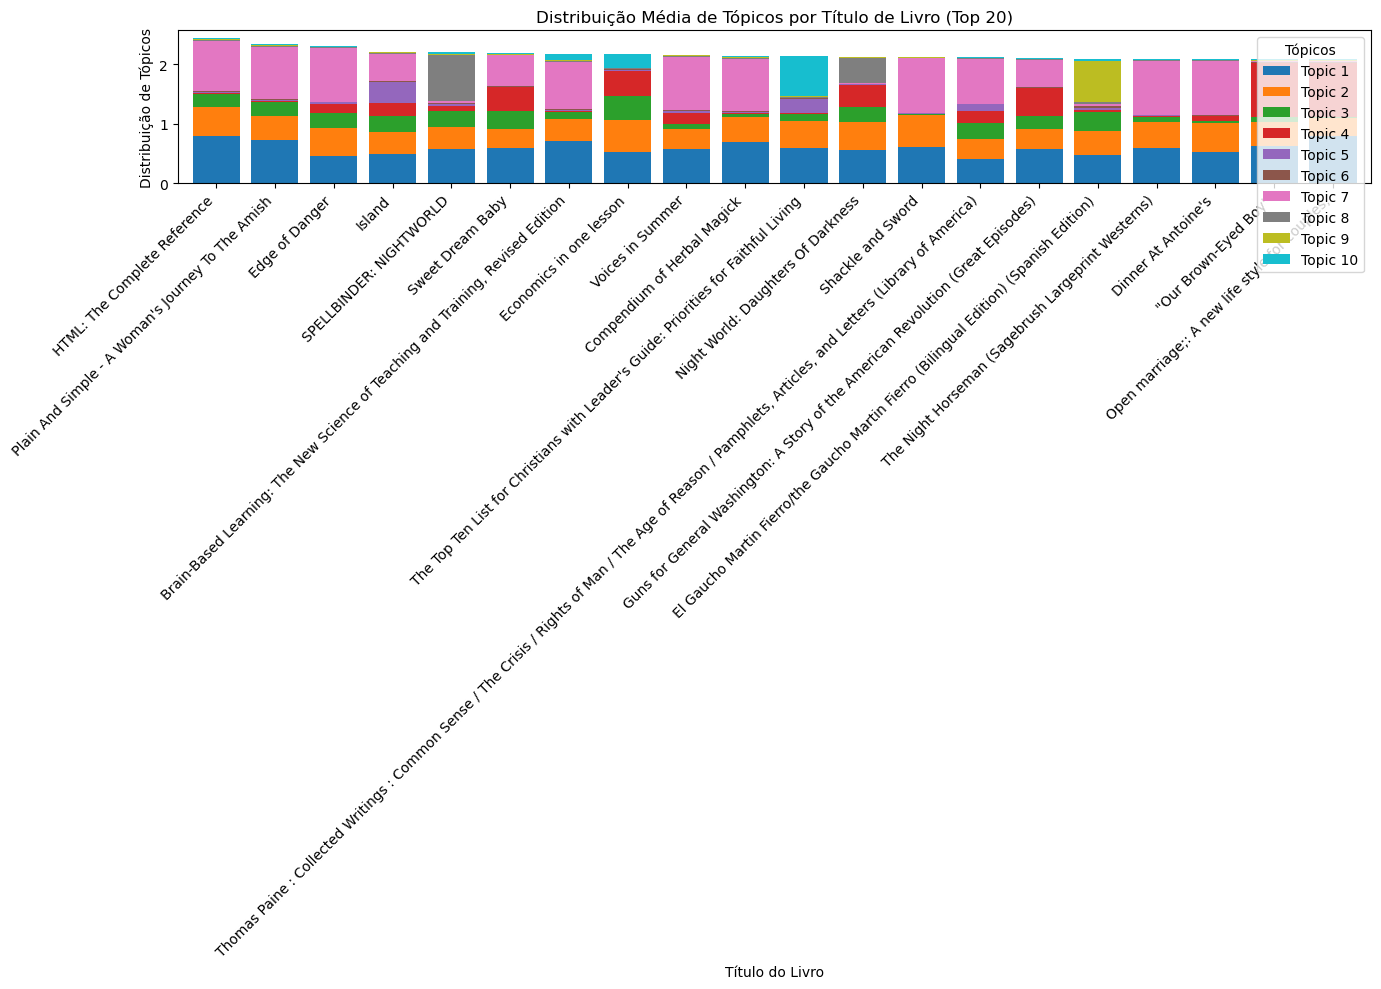

In [35]:
import matplotlib.pyplot as plt

# Obter a distribuição de tópicos para cada documento no corpus
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Converter as distribuições de tópicos em um DataFrame para facilitar a visualização
topic_dist_df = pd.DataFrame([[topic[1] for topic in doc] for doc in topic_distributions])
topic_dist_df.columns = [f'Topic {i+1}' for i in range(topic_dist_df.shape[1])]
topic_dist_df['Title'] = books_rating['Title']

# Calculando a média dos tópicos por livro
average_topic_dist = topic_dist_df.groupby('Title').mean()

# Selecionando os 20 títulos com maior distribuição de tópicos para visualização
top_titles = average_topic_dist.sum(axis=1).nlargest(20).index
average_topic_dist_top = average_topic_dist.loc[top_titles]

# Visualizando a distribuição média dos tópicos por título de livro
plt.figure(figsize=(14, 10))
average_topic_dist_top.plot(kind='bar', stacked=True, figsize=(14, 10), width=0.8)
plt.title("Distribuição Média de Tópicos por Título de Livro (Top 20)")
plt.xlabel("Título do Livro")
plt.ylabel("Distribuição de Tópicos")
plt.legend(title="Tópicos")
plt.xticks(rotation=45, ha="right")  # Rotação nos rótulos do eixo X
plt.tight_layout()
plt.show();


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import textwrap

texto = """Aqui estão os primeiros resultados dos livros agrupados por similaridade, com cada título associado a um cluster específico (de 0 a 4). 
        Esse agrupamento indica quais livros possuem conteúdo semelhante, conforme analisado pelo modelo K-Means usando TF-IDF."""

texto_ajustado = textwrap.fill(texto, width=60)


# Convertendo a coluna 'stemmed_text' para uma lista de strings, unindo tokens com espaço
documents = [" ".join(text) if isinstance(text, list) else text for text in books_rating['stemmed_text']]

# Aplicando o TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Definindo o número de clusters e aplicando o KMeans
num_clusters = 5  # Podemos ajustar este número conforme necessário

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
books_rating['Cluster'] = kmeans.fit_predict(tfidf_matrix)

# Exibindo os títulos dos livros com os clusters atribuídos
df_clustered = books_rating[['Title', 'Cluster', 'text']]

print(texto_ajustado,"\n")
df_clustered.head(6)

Aqui estão os primeiros resultados dos livros agrupados por
similaridade, com cada título associado a um cluster
específico (de 0 a 4).          Esse agrupamento indica
quais livros possuem conteúdo semelhante, conforme analisado
pelo modelo K-Means usando TF-IDF. 



/home/mborges/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Title,Cluster,text
0,Its Only Art If Its Well Hung!,3,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,3,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,3,"If people become the books they read and if ""t..."
3,Dr. Seuss: American Icon,3,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Dr. Seuss: American Icon,3,Philip Nel - Dr. Seuss: American IconThis is b...
5,Dr. Seuss: American Icon,3,"""Dr. Seuss: American Icon"" by Philip Nel is a ..."


In [37]:
# Obtenção dos termos principais para cada cluster com base nos centróides do K-Means

# Cada linha em cluster_centers_ é um centróide de cluster com os pesos dos termos
terms = tfidf_vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]  # Ordena os índices dos termos por peso

# Coletando os principais termos para cada cluster
top_terms_per_cluster = {}
for i in range(num_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]  # Pega os 10 termos mais representativos
    top_terms_per_cluster[f'Cluster {i}'] = top_terms

# Convertendo para DataFrame para melhor visualização
top_terms_df = pd.DataFrame.from_dict(top_terms_per_cluster, orient='index', columns=[f'Term {i+1}' for i in range(10)])

# Exibindo a tabela com os termos principais de cada cluster
top_terms_df


,Term 1,Term 2,Term 3,Term 4,Term 5,Term 6,Term 7,Term 8,Term 9,Term 10
Cluster 0,book,read,love,like,one,charact,stori,realli,great,good
Cluster 1,hester,hawthorn,letter,scarlet,novel,sin,read,puritan,book,stori
Cluster 2,econom,hazlitt,book,polici,lesson,govern,read,understand,one,economi
Cluster 3,book,read,great,one,use,stori,good,time,like,author
Cluster 4,de,la,que,lo,el,en,son,version,dr,sin


In [38]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Preparando os documentos para o modelo Doc2Vec
documents = [TaggedDocument(words=" ".join(text).split(), tags=[str(i)]) for i, text in enumerate(books_rating['stemmed_text'])]

# Treinando o modelo Doc2Vec para criar embeddings de cada livro
doc2vec_model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, epochs=40, seed=42)

# Extraindo os vetores para cada livro
book_embeddings = np.array([doc2vec_model.dv[str(i)] for i in range(len(books_rating))])

# Calculando a similaridade de cosseno entre os livros
similarity_matrix = cosine_similarity(book_embeddings)

# Transformando a matriz de similaridade em um DataFrame para facilitar a análise
similarity_df = pd.DataFrame(similarity_matrix, index=books_rating['Title'], columns=books_rating['Title'])

# Exibindo uma amostra da matriz de similaridade
similarity_df.iloc[:10, :10]  # Exibindo apenas uma parte para evitar excesso de dados


Title,Its Only Art If Its Well Hung!,Dr. Seuss: American Icon,Dr. Seuss: American Icon,Dr. Seuss: American Icon,Dr. Seuss: American Icon,Dr. Seuss: American Icon,Dr. Seuss: American Icon,Dr. Seuss: American Icon,Dr. Seuss: American Icon,Dr. Seuss: American Icon
Title,,,,,,,,,,
Its Only Art If Its Well Hung!,1.000000,0.076117,-0.059608,0.143907,0.186799,0.023436,0.147551,0.386949,0.346814,0.200969
Dr. Seuss: American Icon,0.076117,1.000000,0.614396,0.498634,0.534215,0.614330,0.550508,0.402642,0.319762,0.535374
Dr. Seuss: American Icon,-0.059608,0.614396,1.000000,0.695135,0.625975,0.588857,0.626849,0.373635,0.290980,0.604725
Dr. Seuss: American Icon,0.143907,0.498634,0.695135,1.000000,0.488121,0.636952,0.650863,0.517094,0.315276,0.633797
Dr. Seuss: American Icon,0.186799,0.534215,0.625975,0.488121,1.000000,0.491020,0.450935,0.573485,0.246305,0.658328
Dr. Seuss: American Icon,0.023436,0.614330,0.588857,0.636952,0.491020,1.000000,0.693827,0.403698,0.348834,0.677304
Dr. Seuss: American Icon,0.147551,0.550508,0.626849,0.650863,0.450935,0.693827,1.000000,0.415991,0.392183,0.655184
Dr. Seuss: American Icon,0.386949,0.402642,0.373635,0.517094,0.573485,0.403698,0.415991,1.000000,0.343425,0.459730
Dr. Seuss: American Icon,0.346814,0.319762,0.290980,0.315276,0.246305,0.348834,0.392183,0.343425,1.000000,0.293053


/tmp/ipykernel_12481/400151537.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")


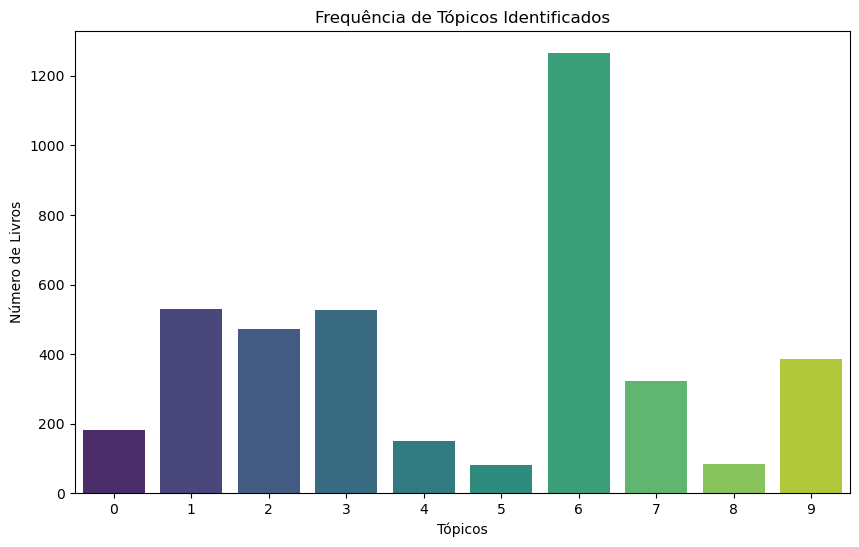

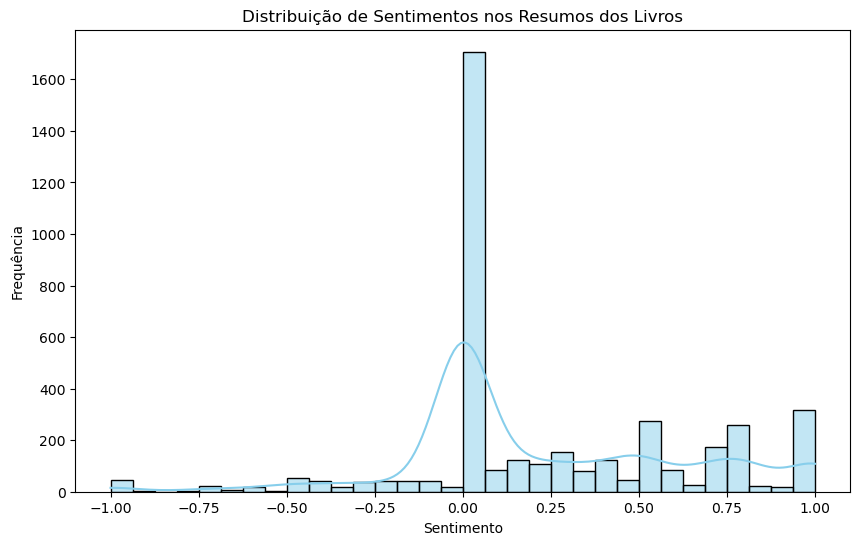

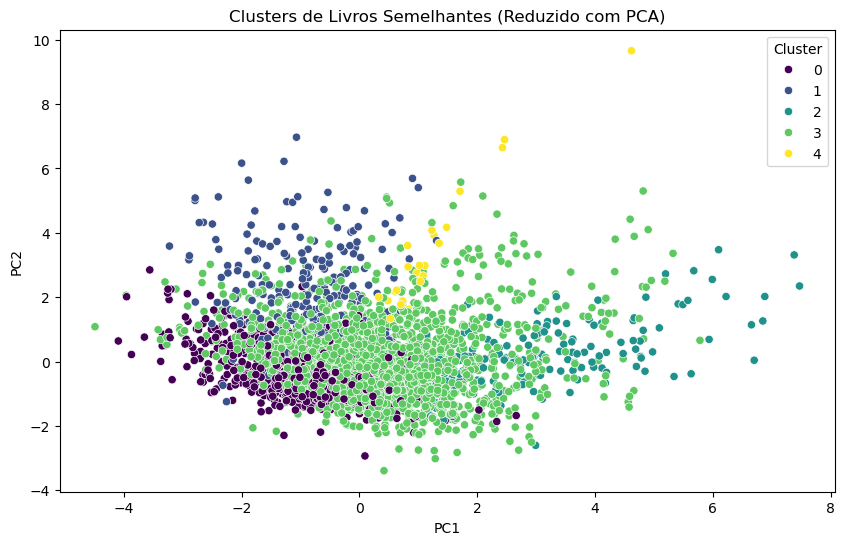

In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Visualização 1: Frequência de Tópicos
if 'Dominant_Topic' in books_rating.columns:
    topic_counts = books_rating['Dominant_Topic'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
    plt.title("Frequência de Tópicos Identificados")
    plt.xlabel("Tópicos")
    plt.ylabel("Número de Livros")
    plt.show()

# Visualização 2: Distribuição de Sentimentos
if 'summary_sentiment' in books_rating.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(books_rating['summary_sentiment'], kde=True, color='skyblue')
    plt.title("Distribuição de Sentimentos nos Resumos dos Livros")
    plt.xlabel("Sentimento")
    plt.ylabel("Frequência")
    plt.show()

# Visualização 3: Clusters de Livros Semelhantes (PCA)
if 'Cluster' in books_rating.columns:
    # Reduzindo a dimensionalidade com PCA para visualização
    pca = PCA(n_components=2)
    book_embeddings_2d = pca.fit_transform(book_embeddings)

    # Criando um DataFrame para visualização
    cluster_df = pd.DataFrame(book_embeddings_2d, columns=['PC1', 'PC2'])
    cluster_df['Cluster'] = books_rating['Cluster']

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=cluster_df, palette="viridis", legend="full")
    plt.title("Clusters de Livros Semelhantes (Reduzido com PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster")
    plt.show();
